# Automatyzacja pracy z danymi przestrzennymi w Pythonie i GeoPandas

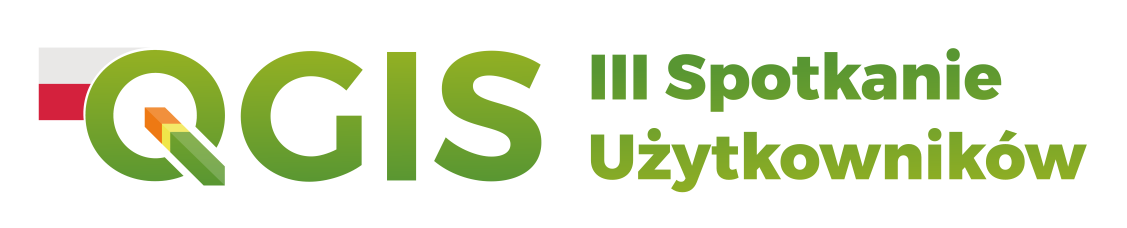

## Meta


- **Prowadzący**: Szymon Moliński (Digitree SA)
- **Data**: 2024-06-26
- **Miejsce**: Poznań
- **Część**: 5

Projekt bazuje na: https://ml-gis-service.com/index.php/2021/03/19/data-science-feature-engineering-with-spatial-flavour/

In [ ]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
from shapely.geometry import Point

from geopandas import points_from_xy

In [ ]:
# Set project files
zip = "zip://"
dpath = "/content/drive/MyDrive/geopandas-workshops/"

baseline_dataset = dpath + 'AB_NYC_2019.csv'
baseline_id_column = 'id'

boroughs = zip + dpath + 'nybbwi_20d.zip!nybbwi_20d/nybbwi.shp'
fire_divs = zip + dpath + 'nyfd_20d.zip!nyfd_20d/nyfd.shp'
health_cns = zip + dpath + 'nyhc_20d.zip!nyhc_20d/nyhc.shp'
police_prs = zip + dpath + 'nypp_20d.zip!nypp_20d/nypp.shp'
school_dis = zip + dpath + 'nysd_20d.zip!nysd_20d/nysd.shp'

In [ ]:
df = pd.read_csv(baseline_dataset,
                 index_col=baseline_id_column)

In [ ]:
df.sample(3)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
29566272,Huge Apartment in the Heart of Bushwick,2897622,Jordan,Brooklyn,Bushwick,40.69786,-73.93125,Entire home/apt,200,6,1,2018-12-07,0.14,1,26
31211324,"Spacious, cute room in great location",233423542,Asheera,Queens,Astoria,40.76681,-73.92850,Private room,75,3,0,NaN,NaN,2,0
34813915,"Beauty Apt ,Shared Room in Hell's Kitchen 6",262360035,Kuzey,Manhattan,Hell's Kitchen,40.76558,-73.98785,Shared room,75,1,3,2019-06-30,1.76,6,365


In [ ]:
# Spatial data sources

gdf_boroughs = gpd.read_file(boroughs)
gdf_fire_divs = gpd.read_file(fire_divs)
gdf_police_prs = gpd.read_file(police_prs)
gdf_school_dis = gpd.read_file(school_dis)
gdf_health_cns = gpd.read_file(health_cns)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroCode    30 non-null     int64   
 1   BoroName    30 non-null     object  
 2   HCentDist   30 non-null     int64   
 3   Shape_Leng  30 non-null     float64 
 4   Shape_Area  30 non-null     float64 
 5   geometry    30 non-null     geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 1.5+ KB
None
EPSG:2263


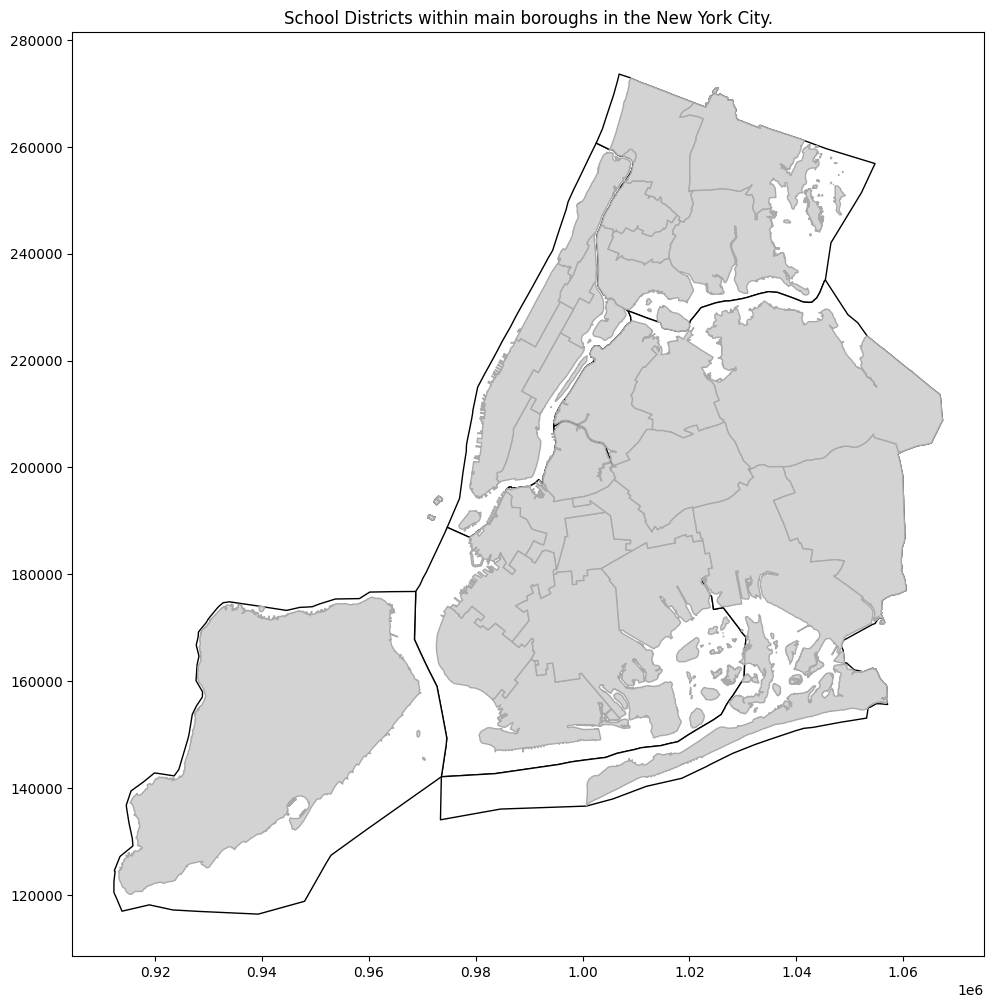

In [ ]:
print(gdf_health_cns.info())
print(gdf_health_cns.crs)
base = gdf_boroughs.plot(color='white', edgecolor='black', figsize=(12, 12))
gdf_health_cns.plot(ax=base, color='lightgray', edgecolor='darkgray');
plt.title('School Districts within main boroughs in the New York City.');

## Transformacja zwykłej tabelki do zbioru przestrzennego

In [ ]:
points = points_from_xy(x=df['longitude'], y=df['latitude'], crs="EPSG:4326")

In [ ]:
df['geometry'] = points

In [ ]:
gdf = gpd.GeoDataFrame(df[
      ['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
      'minimum_nights', 'number_of_reviews','reviews_per_month',
      'calculated_host_listings_count', 'geometry']
    ])

In [ ]:
gdf.dropna(axis=0, inplace=True)

In [ ]:
gdf.drop_duplicates(inplace=True)

In [ ]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [ ]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf.geometry

id
2539        POINT (-73.97237 40.64749)
2595        POINT (-73.98377 40.75362)
3831        POINT (-73.95976 40.68514)
5022        POINT (-73.94399 40.79851)
5099        POINT (-73.97500 40.74767)
                       ...            
36425863    POINT (-73.95366 40.78099)
36427429    POINT (-73.81459 40.75104)
36438336    POINT (-74.14275 40.54179)
36442252    POINT (-73.92400 40.80787)
36455809    POINT (-73.92801 40.69805)
Name: geometry, Length: 38843, dtype: geometry

In [ ]:
gdf.to_crs(gdf_boroughs.crs, inplace=True)

In [ ]:
gdf.crs == gdf_boroughs.crs

True

## Stworzenie przestrzennych cech do analiz statystycznych

In [ ]:
# Krok 1: czy dzielnica ma w ogóle wpływ na ceny?

Text(0.5, 1.0, 'Distribution of price in relation to categorical variables: Boroughs.')

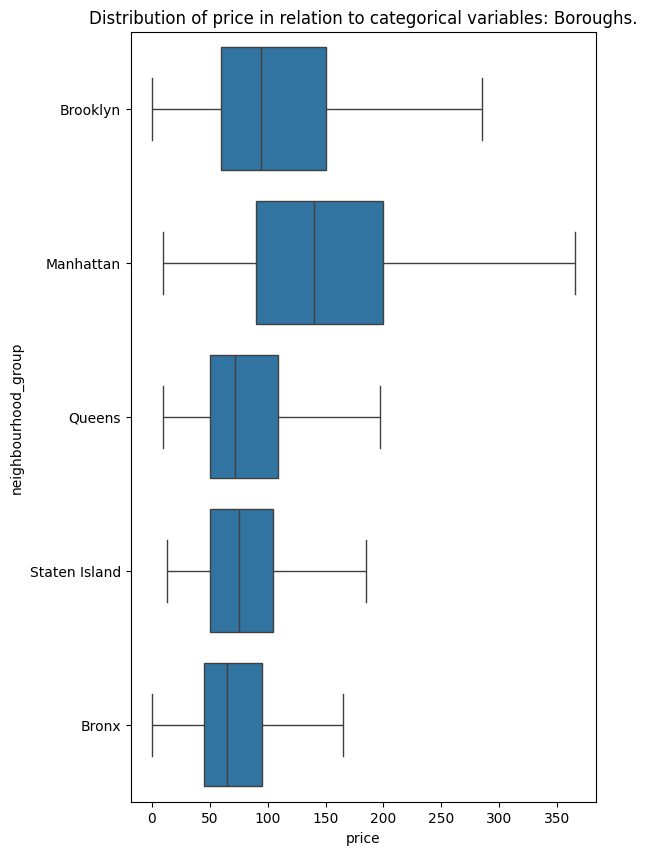

In [ ]:
plt.figure(figsize=(6, 10))
sns.boxplot(y='neighbourhood_group', x='price',
            data=gdf, orient='h', showfliers=False)
plt.title('Distribution of price in relation to categorical variables: Boroughs.')

In [ ]:
# Krok 2: zmienna numeryczna przydatna w modelowaniu - dystans do centrum dzielnicy od każdego apartamentu

In [ ]:
# Get borough centroids

gdf_boroughs['centroids'] = gdf_boroughs.centroid

In [ ]:
# Create n numerical columns
# n = number of boroughs

for bname in gdf_boroughs['BoroName'].unique():
    district_name = 'cdist_' + bname
    cent = gdf_boroughs[gdf_boroughs['BoroName'] == bname]['centroids'].values[0]
    gdf[district_name] = gdf['geometry'].distance(cent)

In [ ]:
# Make a copy of dataframe before any join

ext_gdf = gdf.copy()

# Join Fire Divisions

ext_gdf = gpd.sjoin(ext_gdf, gdf_fire_divs[['geometry', 'FireDiv']], how='left', predicate='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

# Join Health Centers

ext_gdf = gpd.sjoin(ext_gdf, gdf_health_cns[['geometry', 'HCentDist']], how='left', predicate='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

# Join Police Precincts

ext_gdf = gpd.sjoin(ext_gdf, gdf_police_prs[['geometry', 'Precinct']], how='left', predicate='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

# Join School Districts

ext_gdf = gpd.sjoin(ext_gdf, gdf_school_dis[['geometry', 'SchoolDist']], how='left', predicate='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

# We have to transform categorical columns to be sure that we don't get strange results

categorical_columns = ['FireDiv', 'HCentDist', 'Precinct', 'SchoolDist']
ext_gdf[categorical_columns] = ext_gdf[categorical_columns].astype('category')

In [ ]:
# Check corr with numerical

ext_gdf.corrwith(ext_gdf['price'], numeric_only=True).sort_values()

cdist_Manhattan                  -0.146215
cdist_Staten Island              -0.058386
number_of_reviews                -0.035938
reviews_per_month                -0.030608
cdist_Bronx                       0.011227
cdist_Brooklyn                    0.011877
minimum_nights                    0.025506
calculated_host_listings_count    0.052903
cdist_Queens                      0.096206
price                             1.000000
dtype: float64